<a href="https://colab.research.google.com/github/lfa-systems/Telecom-X-Parte-2/blob/main/TelecomX_BR_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Missão
Sua nova missão é desenvolver modelos preditivos capazes de prever quais clientes têm maior chance de cancelar seus serviços.

A empresa quer antecipar o problema da evasão, e cabe a você construir um pipeline robusto para essa etapa inicial de modelagem.



* Preparar os dados para a modelagem (tratamento, encoding, normalização).
* Realizar análise de correlação e seleção de variáveis.
* Treinar dois ou mais modelos de classificação.
* Avaliar o desempenho dos modelos com métricas.
* Interpretar os resultados, incluindo a importância das variáveis.
* Criar uma conclusão estratégica apontando os principais fatores que influenciam a evasão.

#<font color='#120825'> **Preparar os dados para a modelagem**

### 🗃️ Importação das bibliotecas


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib



### 🤔 Entendendo o conjunto de dados

In [2]:
url='https://raw.githubusercontent.com/lfa-systems/Telecom-X-Parte-2/refs/heads/main/dados/TelecomX_Data.json'
df=pd.read_json(url)

In [3]:
# Mostrar dados
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [4]:
# Transformar colunas de dicionários para coluna com prefixo da coluna original
for nome_coluna in df.columns:
    if isinstance(df[nome_coluna].iloc[0], dict):
       temp_normalizado = pd.json_normalize(df[nome_coluna])
       df = pd.concat([df, temp_normalizado.add_prefix(f'{nome_coluna}_')], axis=1).drop(nome_coluna, axis=1)

df.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [5]:
df.tail()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65
7266,9995-HOTOH,No,Male,0,Yes,Yes,63,No,No phone service,DSL,...,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,59.00,3707.6


In [6]:
# Retornar a quantidade de linhas e colunas do dataframe
df.shape

(7267, 21)

In [7]:
# Verificar o nome de cada coluna, a quantidade de dados não nulos existente na coluna em questão e o tipo de dado.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSupport       7267 non-null   objec

In [8]:
# Conhecendo valores únicos das colunas
for nome_coluna in df.columns:
    print(f'{nome_coluna}\n',df[nome_coluna].unique())

customerID
 ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn
 ['No' 'Yes' '']
customer_gender
 ['Female' 'Male']
customer_SeniorCitizen
 [0 1]
customer_Partner
 ['Yes' 'No']
customer_Dependents
 ['Yes' 'No']
customer_tenure
 [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]
phone_PhoneService
 ['Yes' 'No']
phone_MultipleLines
 ['No' 'Yes' 'No phone service']
internet_InternetService
 ['DSL' 'Fiber optic' 'No']
internet_OnlineSecurity
 ['No' 'Yes' 'No internet service']
internet_OnlineBackup
 ['Yes' 'No' 'No internet service']
internet_DeviceProtection
 ['No' 'Yes' 'No internet service']
internet_TechSupport
 ['Yes' 'No' 'No internet service']
internet_StreamingTV
 ['Yes' 'No' 'No internet service']
internet_StreamingMovies
 ['No' 'Yes' 'No internet service']
account_Contrac

#<font color='#120825'> **Realizar análise de correlação e seleção de variáveis.**

### 🚮 Limpando os Dados

In [9]:
# Coluna não ajuda na predisão
df = df.drop(['customerID'], axis=1)

In [10]:
df.head()

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [11]:
# Verificar colunas com valores vazio
mascara_espaco = (df.isin(['',' ']))
colunas_com_espaco_booleano = mascara_espaco.any(axis=0)
colunas_com_espaco = colunas_com_espaco_booleano[colunas_com_espaco_booleano].index.tolist()
colunas_com_espaco

['Churn', 'account_Charges.Total']

In [12]:
# Assumir Churn '' como não
df.loc[df['Churn'] == '', 'Churn'] = 'No'

In [13]:
# Assumir que seja clientes novos estão sem valor de account_Charges.Total
df[(df['account_Charges.Total'] == '') | (df['account_Charges.Total'] == ' ')]

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
975,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
1775,No,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,
1955,No,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
2075,No,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
2232,No,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2308,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
2930,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,
3134,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,
3203,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
4169,No,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,


In [14]:
# Mudar tipo da coluna account_Charges.Total para números
df['account_Charges.Total'] = pd.to_numeric(df['account_Charges.Total'], errors='coerce')

In [15]:
# A coluna 'customer_SeniorCitizen' está como numérica (0/1), mas é categórica.
# Vamos convertê-la para string para ser tratada como categórica.
df['customer_SeniorCitizen'] = df['customer_SeniorCitizen'].astype(object)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7267 non-null   object 
 1   customer_gender            7267 non-null   object 
 2   customer_SeniorCitizen     7267 non-null   object 
 3   customer_Partner           7267 non-null   object 
 4   customer_Dependents        7267 non-null   object 
 5   customer_tenure            7267 non-null   int64  
 6   phone_PhoneService         7267 non-null   object 
 7   phone_MultipleLines        7267 non-null   object 
 8   internet_InternetService   7267 non-null   object 
 9   internet_OnlineSecurity    7267 non-null   object 
 10  internet_OnlineBackup      7267 non-null   object 
 11  internet_DeviceProtection  7267 non-null   object 
 12  internet_TechSupport       7267 non-null   object 
 13  internet_StreamingTV       7267 non-null   objec

In [17]:
# Considerando que o cliente ainda não "tem total gasto pelo cliente" é cliente novo
novos_cliente = df[df['account_Charges.Total'].isna()]
novos_cliente

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
975,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN
1775,No,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN
1955,No,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
2075,No,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN
2232,No,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN
2308,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
2930,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN
3134,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN
3203,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
4169,No,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN


In [18]:
novos_cliente['customer_SeniorCitizen'] = novos_cliente['customer_SeniorCitizen'].astype(object)

/tmp/ipython-input-1821822443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novos_cliente['customer_SeniorCitizen'] = novos_cliente['customer_SeniorCitizen'].astype(object)


In [19]:
# Estatísticas Descritivas (Numéricas)
df.describe()

,customer_tenure,account_Charges.Monthly,account_Charges.Total
count,7267.000000,7267.000000,7256.000000
mean,32.346498,64.720098,2280.634213
std,24.571773,30.129572,2268.632997
min,0.000000,18.250000,18.800000
25%,9.000000,35.425000,400.225000
50%,29.000000,70.300000,1391.000000
75%,55.000000,89.875000,3785.300000
max,72.000000,118.750000,8684.800000


In [20]:
# Estatísticas Descritivas (Categóricas)
df.describe(include='O')

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod
count,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267
unique,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,No,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,5398,3675,6085,3749,5086,6560,3495,3198,3608,3182,3195,3582,2896,2870,4005,4311,2445


In [21]:
# Mostrar valores ausentes
df.isnull().sum()

,0
Churn,0
customer_gender,0
customer_SeniorCitizen,0
customer_Partner,0
customer_Dependents,0
customer_tenure,0
phone_PhoneService,0
phone_MultipleLines,0
internet_InternetService,0
internet_OnlineSecurity,0


In [22]:
# Remover possiveis novos clientes
df = df.dropna(subset=['account_Charges.Total'])


In [23]:
# Mostrar valores ausentes
df.isnull().sum()

,0
Churn,0
customer_gender,0
customer_SeniorCitizen,0
customer_Partner,0
customer_Dependents,0
customer_tenure,0
phone_PhoneService,0
phone_MultipleLines,0
internet_InternetService,0
internet_OnlineSecurity,0


#<font color='#120825'> **Treinar dois ou mais modelos de classificação.**

## ⚙️ Preparação dos Dados para o Modelo

In [24]:
# Separando features (X) e target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [25]:
# Convertendo a variável target para 0 e 1
y = y.replace({'Yes': 1, 'No': 0})

/tmp/ipython-input-4233336569.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'Yes': 1, 'No': 0})


In [26]:
# Separando colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

## 🇵 Criação de Pipelines de Pré-processamento e Modelagem

In [28]:
# Criando os transformadores para as colunas
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [29]:
# Usando ColumnTransformer para aplicar as transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## ⛹ Treinamento e Avaliação do Modelo (Random Forest)


In [30]:
# Criando um pipeline completo com o pré-processamento e o modelo
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [31]:
# Definindo o grid de parâmetros para o GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [32]:
# Usando GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(model_rf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['customer_gender', 'customer_SeniorCitizen', 'customer_Partner',
       'customer_Dependents', 'pho...
       'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

In [33]:
# Melhores parâmetros encontrados
print(grid_search.best_params_)

{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}


In [34]:
# Avaliando o modelo com os melhores parâmetros no conjunto de teste
best_model_rf = grid_search.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)


In [35]:
# Relatório de Classificação do Random Forest
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1347
           1       0.62      0.46      0.53       467

    accuracy                           0.79      1814
   macro avg       0.72      0.68      0.70      1814
weighted avg       0.78      0.79      0.78      1814



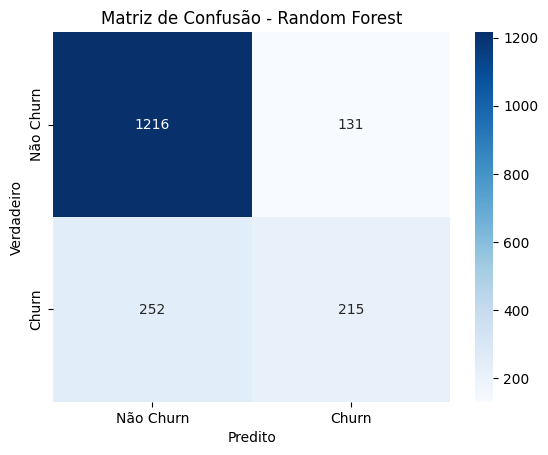

In [36]:
# Matriz de Confusão do Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'])
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

## ⛹ Treinamento e Avaliação do Modelo (XGBoost)

In [37]:
# Criando o pipeline para o modelo XGBoost
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

#<font color='#120825'> **Avaliar o desempenho dos modelos com métricas.**

In [38]:
# Definindo o grid de parâmetros para o XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

In [39]:
# Usando GridSearchCV Treinando o modelo XGBoost com GridSearchCV
grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:14:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['customer_gender', 'customer_SeniorCitizen', 'customer_Partner',
       'customer_Dependents', 'pho...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [40]:
print(grid_search_xgb.best_params_)


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


In [41]:
# Avaliando o modelo com os melhores parâmetros
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

In [42]:
# Relatório de Classificação do XGBoost
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1347
           1       0.64      0.50      0.56       467

    accuracy                           0.80      1814
   macro avg       0.74      0.70      0.71      1814
weighted avg       0.79      0.80      0.79      1814



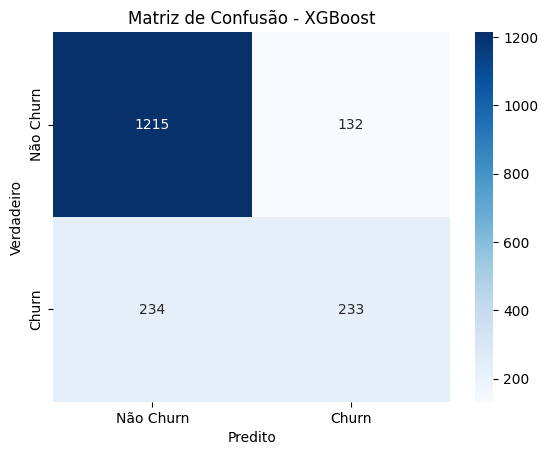

In [43]:
# Matriz de Confusão do XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'])
plt.title('Matriz de Confusão - XGBoost')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()


## 👼 Predição em Novos Dados Fictícios


In [44]:
df.head()

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [45]:
# Pegar uma amostra aleatória de 10 registros Churn
clientes_com_churn = df[df['Churn'] == 'Yes']
amostra_aleatoria_churn = clientes_com_churn.sample(n=10)

In [46]:
# Colunas para testes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7256 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7256 non-null   object 
 1   customer_gender            7256 non-null   object 
 2   customer_SeniorCitizen     7256 non-null   object 
 3   customer_Partner           7256 non-null   object 
 4   customer_Dependents        7256 non-null   object 
 5   customer_tenure            7256 non-null   int64  
 6   phone_PhoneService         7256 non-null   object 
 7   phone_MultipleLines        7256 non-null   object 
 8   internet_InternetService   7256 non-null   object 
 9   internet_OnlineSecurity    7256 non-null   object 
 10  internet_OnlineBackup      7256 non-null   object 
 11  internet_DeviceProtection  7256 non-null   object 
 12  internet_TechSupport       7256 non-null   object 
 13  internet_StreamingTV       7256 non-null   object 
 1

In [47]:
# Função para uso de um DataFrame com dados de clientes "Fictícios" para teste.
# As colunas precisam ser as mesmas que as do conjunto de treino.
def predicao(new_clients, modelo_rf=best_model_rf, modelo_xgb=best_model_xgb):
  # Fazendo as previsões com o melhor modelo de Random Forest
  rf_predictions = best_model_rf.predict(new_clients)
  rf_probabilities = best_model_rf.predict_proba(new_clients)[:, 1] # Probabilidade de Churn

  print("\n--- Previsões do Random Forest para os novos clientes ---")
  for i in range(len(new_clients)):
      prediction = 'SIM' if rf_predictions[i] == 1 else 'NÃO'
      print(f"Cliente {i+1} | {new_clients.index[i]}: Possibilidade de Churn: {prediction}, Probabilidade: {rf_probabilities[i]:.2f}")

  # Fazendo as previsões com o melhor modelo XGBoost
  xgb_predictions = best_model_xgb.predict(new_clients)
  xgb_probabilities = best_model_xgb.predict_proba(new_clients)[:, 1] # Probabilidade de Churn

  print("\n--- Previsões do XGBoost para os novos clientes ---")
  for i in range(len(new_clients)):
      prediction = 'SIM' if xgb_predictions[i] == 1 else 'NÃO'
      print(f"Cliente {i+1} | {new_clients.index[i]}: Possibilidade de Churn: {prediction}, Probabilidade: {xgb_probabilities[i]:.2f}")

In [48]:
# Predição dos novos clientes
predicao(novos_cliente)
novos_cliente



--- Previsões do Random Forest para os novos clientes ---
Cliente 1 | 975: Possibilidade de Churn: NÃO, Probabilidade: 0.07
Cliente 2 | 1775: Possibilidade de Churn: NÃO, Probabilidade: 0.03
Cliente 3 | 1955: Possibilidade de Churn: NÃO, Probabilidade: 0.12
Cliente 4 | 2075: Possibilidade de Churn: NÃO, Probabilidade: 0.08
Cliente 5 | 2232: Possibilidade de Churn: NÃO, Probabilidade: 0.04
Cliente 6 | 2308: Possibilidade de Churn: NÃO, Probabilidade: 0.03
Cliente 7 | 2930: Possibilidade de Churn: NÃO, Probabilidade: 0.11
Cliente 8 | 3134: Possibilidade de Churn: NÃO, Probabilidade: 0.03
Cliente 9 | 3203: Possibilidade de Churn: NÃO, Probabilidade: 0.14
Cliente 10 | 4169: Possibilidade de Churn: NÃO, Probabilidade: 0.09
Cliente 11 | 5599: Possibilidade de Churn: NÃO, Probabilidade: 0.03

--- Previsões do XGBoost para os novos clientes ---
Cliente 1 | 975: Possibilidade de Churn: NÃO, Probabilidade: 0.04
Cliente 2 | 1775: Possibilidade de Churn: NÃO, Probabilidade: 0.02
Cliente 3 | 1955:

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
975,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN
1775,No,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN
1955,No,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
2075,No,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN
2232,No,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN
2308,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
2930,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN
3134,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN
3203,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
4169,No,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN


In [49]:
# Predição de uma amostra aleatória
predicao(amostra_aleatoria_churn)
amostra_aleatoria_churn


--- Previsões do Random Forest para os novos clientes ---
Cliente 1 | 1438: Possibilidade de Churn: SIM, Probabilidade: 0.51
Cliente 2 | 1820: Possibilidade de Churn: NÃO, Probabilidade: 0.46
Cliente 3 | 1231: Possibilidade de Churn: SIM, Probabilidade: 0.83
Cliente 4 | 4129: Possibilidade de Churn: SIM, Probabilidade: 0.63
Cliente 5 | 2010: Possibilidade de Churn: SIM, Probabilidade: 0.56
Cliente 6 | 3308: Possibilidade de Churn: NÃO, Probabilidade: 0.33
Cliente 7 | 2635: Possibilidade de Churn: SIM, Probabilidade: 0.61
Cliente 8 | 3137: Possibilidade de Churn: SIM, Probabilidade: 0.59
Cliente 9 | 2647: Possibilidade de Churn: NÃO, Probabilidade: 0.38
Cliente 10 | 2663: Possibilidade de Churn: NÃO, Probabilidade: 0.34

--- Previsões do XGBoost para os novos clientes ---
Cliente 1 | 1438: Possibilidade de Churn: NÃO, Probabilidade: 0.41
Cliente 2 | 1820: Possibilidade de Churn: NÃO, Probabilidade: 0.45
Cliente 3 | 1231: Possibilidade de Churn: SIM, Probabilidade: 0.83
Cliente 4 | 4129

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
1438,Yes,Female,1,No,No,7,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),76.45,503.60
1820,Yes,Male,0,No,No,3,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,24.75,66.95
1231,Yes,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.55,79.55
4129,Yes,Male,1,No,No,49,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.20,4718.25
2010,Yes,Male,1,Yes,No,24,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.15,2231.05
3308,Yes,Female,1,No,No,56,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),104.75,5510.65
2635,Yes,Male,0,Yes,No,4,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,80.60,319.15
3137,Yes,Female,0,Yes,Yes,14,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),90.90,1259.00
2647,Yes,Male,0,No,No,58,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,104.65,6219.60
2663,Yes,Female,0,No,No,32,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,One year,No,Electronic check,84.05,2781.85


### 💾 Salvando o modelo

In [50]:
# SALVAR O MODELO
try:
    filename = 'best_xgb_model.joblib'
    joblib.dump(best_model_xgb, filename)
    print(f"Modelo salvo com sucesso no arquivo: {filename}")
except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")

try:
    filename = 'best_model_rf.joblib'
    joblib.dump(best_model_rf, filename)
    print(f"Modelo salvo com sucesso no arquivo: {filename}")
except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")




Modelo salvo com sucesso no arquivo: best_xgb_model.joblib
Modelo salvo com sucesso no arquivo: best_model_rf.joblib


In [51]:
# CARREGAR O MODELO
try:
    filename = 'best_xgb_model.joblib'
    modelo_best_xgb_model_carregado = joblib.load(filename)
    print(f"\nModelo carregado com sucesso do arquivo: {filename}")
except FileNotFoundError:
    print(f"\nErro: O arquivo '{filename}' não foi encontrado. Certifique-se de ter salvo o modelo primeiro.")
    modelo_best_xgb_model_carregado = None # Para evitar erro no passo seguinte

try:
    filename = 'best_model_rf.joblib'
    modelo_best_model_rf_carregado = joblib.load(filename)
    print(f"\nModelo carregado com sucesso do arquivo: {filename}")
except FileNotFoundError:
    print(f"\nErro: O arquivo '{filename}' não foi encontrado. Certifique-se de ter salvo o modelo primeiro.")
    modelo_best_model_rf_carregado = None # Para evitar erro no passo seguinte




Modelo carregado com sucesso do arquivo: best_xgb_model.joblib

Modelo carregado com sucesso do arquivo: best_model_rf.joblib


In [52]:
# Predição dos novos clientes
predicao(novos_cliente,modelo_best_model_rf_carregado,modelo_best_xgb_model_carregado)
novos_cliente


--- Previsões do Random Forest para os novos clientes ---
Cliente 1 | 975: Possibilidade de Churn: NÃO, Probabilidade: 0.07
Cliente 2 | 1775: Possibilidade de Churn: NÃO, Probabilidade: 0.03
Cliente 3 | 1955: Possibilidade de Churn: NÃO, Probabilidade: 0.12
Cliente 4 | 2075: Possibilidade de Churn: NÃO, Probabilidade: 0.08
Cliente 5 | 2232: Possibilidade de Churn: NÃO, Probabilidade: 0.04
Cliente 6 | 2308: Possibilidade de Churn: NÃO, Probabilidade: 0.03
Cliente 7 | 2930: Possibilidade de Churn: NÃO, Probabilidade: 0.11
Cliente 8 | 3134: Possibilidade de Churn: NÃO, Probabilidade: 0.03
Cliente 9 | 3203: Possibilidade de Churn: NÃO, Probabilidade: 0.14
Cliente 10 | 4169: Possibilidade de Churn: NÃO, Probabilidade: 0.09
Cliente 11 | 5599: Possibilidade de Churn: NÃO, Probabilidade: 0.03

--- Previsões do XGBoost para os novos clientes ---
Cliente 1 | 975: Possibilidade de Churn: NÃO, Probabilidade: 0.04
Cliente 2 | 1775: Possibilidade de Churn: NÃO, Probabilidade: 0.02
Cliente 3 | 1955:

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
975,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN
1775,No,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN
1955,No,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
2075,No,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN
2232,No,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN
2308,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
2930,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN
3134,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN
3203,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
4169,No,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN


In [53]:
# Predição de uma amostra aleatória
predicao(amostra_aleatoria_churn,modelo_best_model_rf_carregado,modelo_best_xgb_model_carregado)
amostra_aleatoria_churn


--- Previsões do Random Forest para os novos clientes ---
Cliente 1 | 1438: Possibilidade de Churn: SIM, Probabilidade: 0.51
Cliente 2 | 1820: Possibilidade de Churn: NÃO, Probabilidade: 0.46
Cliente 3 | 1231: Possibilidade de Churn: SIM, Probabilidade: 0.83
Cliente 4 | 4129: Possibilidade de Churn: SIM, Probabilidade: 0.63
Cliente 5 | 2010: Possibilidade de Churn: SIM, Probabilidade: 0.56
Cliente 6 | 3308: Possibilidade de Churn: NÃO, Probabilidade: 0.33
Cliente 7 | 2635: Possibilidade de Churn: SIM, Probabilidade: 0.61
Cliente 8 | 3137: Possibilidade de Churn: SIM, Probabilidade: 0.59
Cliente 9 | 2647: Possibilidade de Churn: NÃO, Probabilidade: 0.38
Cliente 10 | 2663: Possibilidade de Churn: NÃO, Probabilidade: 0.34

--- Previsões do XGBoost para os novos clientes ---
Cliente 1 | 1438: Possibilidade de Churn: NÃO, Probabilidade: 0.41
Cliente 2 | 1820: Possibilidade de Churn: NÃO, Probabilidade: 0.45
Cliente 3 | 1231: Possibilidade de Churn: SIM, Probabilidade: 0.83
Cliente 4 | 4129

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
1438,Yes,Female,1,No,No,7,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),76.45,503.60
1820,Yes,Male,0,No,No,3,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,24.75,66.95
1231,Yes,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.55,79.55
4129,Yes,Male,1,No,No,49,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.20,4718.25
2010,Yes,Male,1,Yes,No,24,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.15,2231.05
3308,Yes,Female,1,No,No,56,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),104.75,5510.65
2635,Yes,Male,0,Yes,No,4,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,80.60,319.15
3137,Yes,Female,0,Yes,Yes,14,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),90.90,1259.00
2647,Yes,Male,0,No,No,58,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,104.65,6219.60
2663,Yes,Female,0,No,No,32,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,One year,No,Electronic check,84.05,2781.85


In [54]:
# Conhecendo valores únicos das colunas
for nome_coluna in df.columns:
    valores_unicos = df[nome_coluna].unique()
    x = 10
    if len(valores_unicos) < x:
        amostra_aleatoria = valores_unicos
    else:
        amostra_aleatoria = np.random.choice(valores_unicos, size=x, replace=False)
    print(f'{nome_coluna}: ',amostra_aleatoria)


Churn:  ['No' 'Yes']
customer_gender:  ['Female' 'Male']
customer_SeniorCitizen:  [0 1]
customer_Partner:  ['Yes' 'No']
customer_Dependents:  ['Yes' 'No']
customer_tenure:  [ 6 71 69 31 50 28 64  8 30  1]
phone_PhoneService:  ['Yes' 'No']
phone_MultipleLines:  ['No' 'Yes' 'No phone service']
internet_InternetService:  ['DSL' 'Fiber optic' 'No']
internet_OnlineSecurity:  ['No' 'Yes' 'No internet service']
internet_OnlineBackup:  ['Yes' 'No' 'No internet service']
internet_DeviceProtection:  ['No' 'Yes' 'No internet service']
internet_TechSupport:  ['Yes' 'No' 'No internet service']
internet_StreamingTV:  ['Yes' 'No' 'No internet service']
internet_StreamingMovies:  ['No' 'Yes' 'No internet service']
account_Contract:  ['One year' 'Month-to-month' 'Two year']
account_PaperlessBilling:  ['Yes' 'No']
account_PaymentMethod:  ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
account_Charges.Monthly:  [ 24.3   55.45 117.2   50.1   51.1   68.45 115.8   

In [61]:
# Criando dados de novos clientes fictícios para teste
cliente = pd.DataFrame(
    {
        'Churn'                     : ['No'],       # se o cliente deixou ou não a empresa
        'customer_gender'           : 'Female',     # gênero (masculino e feminino)
        'customer_SeniorCitizen'    : '0',          # informação sobre um cliente ter ou não idade igual ou maior que 65 anos
        'customer_Partner'          : 'No',         # se o cliente possui ou não um parceiro ou parceira
        'customer_Dependents'       : 'No',         # se o cliente possui ou não dependentes
        'customer_tenure'           : 24,           # meses de contrato do cliente
        'phone_PhoneService'        : 'Yes',        # assinatura de serviço telefônico
        'phone_MultipleLines'       : 'No',         # assisnatura de mais de uma linha de telefone
        'internet_InternetService'  : 'Fiber optic',# assinatura de um provedor internet
        'internet_OnlineSecurity'   : 'No',         # assinatura adicional de segurança online
        'internet_OnlineBackup'     : 'No',         # assinatura adicional de backup online
        'internet_DeviceProtection' : 'No',         # assinatura adicional de proteção no dispositivo
        'internet_TechSupport'      : 'Yes',        # assinatura adicional de suporte técnico, menos tempo de espera
        'internet_StreamingTV'      : 'No',        # assinatura de TV a cabo
        'internet_StreamingMovies'  : 'Yes',        # assinatura de streaming de filmes
        'account_Contract'          : 'Month-to-month', # tipo de contrato
        'account_PaperlessBilling'  : 'Yes',        # se o cliente prefere receber online a fatura
        'account_PaymentMethod'     : 'Credit card (automatic)',  # forma de pagamento
        'account_Charges.Monthly'   : 110,          # total de todos os serviços do cliente por mês
        'account_Charges.Total'     : 1100          # total gasto pelo cliente
    }
)

predicao(cliente,modelo_best_model_rf_carregado,modelo_best_xgb_model_carregado)
cliente


--- Previsões do Random Forest para os novos clientes ---
Cliente 1 | 0: Possibilidade de Churn: NÃO, Probabilidade: 0.40

--- Previsões do XGBoost para os novos clientes ---
Cliente 1 | 0: Possibilidade de Churn: NÃO, Probabilidade: 0.30


,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,No,Female,0,No,No,24,Yes,No,Fiber optic,No,No,No,Yes,No,Yes,Month-to-month,Yes,Credit card (automatic),110,1100
